In [1]:
%load_ext autoreload
%autoreload 2
from FEM_utils import *
from sympy import *
import matplotlib.pyplot as plt
import latex
import quadpy
import timeit
from scipy import linalg
import numpy as np
import matplotlib.pyplot as plt

# Mathematical developpement for plane stress Finite Element Method formulation

### Olivier Chabot
### 07/06/2021

# Quadrilateral plane stress element

The quadrilateral plane stress element has 2 ddls per node, the displacement vector for one element goes as follow :

$ u_{i} =  \begin{bmatrix} u_{x} \\ u_{y}  \end{bmatrix} $

The whole displacement vector is : 

$ u_e = \begin{bmatrix} u_1 \\ u_2 \\ u_3 \\ u_4 \end{bmatrix} $

Each element has : $ 4 \times 2 = 8 $ ddls

The general displacement on the element is given by : 

$ \bar{U}(x,y) = N(x,y)u_e $


With $N$ such as : 

$ N = \begin{bmatrix}N_1 & N_2 & N_3 & N_4 \end{bmatrix} $

Where matrices $N_i$, for $u_e$ with 2 ddls, having the shape : 

$ N_i = \begin{bmatrix} N_i(x, y) & 0  \\ 0 & N_i(x, y)  \end{bmatrix} $

We choose the $N_i$ functions so that $N_i = 0$ if $n \neq i$ and $N_i = 1$ if $n = i$

## Shape function of the isoparametric quadrilateral element

We define the base  $\vec{P} = \begin{bmatrix} 1 & \xi & \eta & \xi \eta \end{bmatrix}$

With $\xi$ and $\eta$ the natural coordinates of the reference element : 


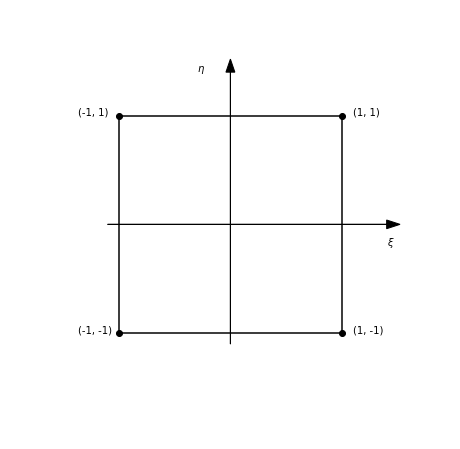

In [3]:
# Graphique d'un élément quadrilatéral linéaire de référence
quad_ref_ele_plot()

In [4]:
# Vecteur P de la base polynomiale pour l'élément
xi, eta = symbols('xi eta')
P_v = Matrix([1, xi, eta, xi*eta]).T
P_v

Matrix([[1, xi, eta, eta*xi]])

The $P$ matrix is computed by evaluating the $\vec{P}$ vector for every node of the reference element :

In [5]:
P = Matrix([[P_v.subs([(xi, -1), (eta, -1)])], # Point 1 (-1, -1)
            [P_v.subs([(xi, 1), (eta, -1)])],  # Point 2 (1, -1)
            [P_v.subs([(xi, 1), (eta, 1)])],  # Point 2 (1, 1)
            [P_v.subs([(xi, -1), (eta, 1)])]])  # Point 2 (-1, 1)
P

Matrix([
[1, -1, -1,  1],
[1,  1, -1, -1],
[1,  1,  1,  1],
[1, -1,  1, -1]])

Shape functions are formed from the equation : $\vec{N} = \vec{P} \times P^{-1}$

Computing the inverse $P^{-1}$ : 

In [6]:
P_inv = P.inv()
P_inv

Matrix([
[ 1/4,  1/4, 1/4,  1/4],
[-1/4,  1/4, 1/4, -1/4],
[-1/4, -1/4, 1/4,  1/4],
[ 1/4, -1/4, 1/4, -1/4]])

Computing the expressions for $\vec{N}$ : 

In [7]:
N = P_v*P_inv
N

Matrix([[eta*xi/4 - eta/4 - xi/4 + 1/4, -eta*xi/4 - eta/4 + xi/4 + 1/4, eta*xi/4 + eta/4 + xi/4 + 1/4, -eta*xi/4 + eta/4 - xi/4 + 1/4]])

Factorizing the components of $\vec{N}$

In [8]:
N = Matrix([factor(n) for n in N]).T
N

Matrix([[(eta - 1)*(xi - 1)/4, -(eta - 1)*(xi + 1)/4, (eta + 1)*(xi + 1)/4, -(eta + 1)*(xi - 1)/4]])

The individual shape function can be written from $\vec{N}$ : 

$ N_1 = \frac{1}{4}(1-\xi)(1-\eta) $

$ N_2 = \frac{1}{4}(1+\xi)(1-\eta) $ 

$ N_3 = \frac{1}{4}(1+\xi)(1+\eta) $

$ N_4 = \frac{1}{4}(1-\xi)(1+\eta) $ 

We validate the shape of the $N_i$ by plotting them in the subdomain $\xi, \eta = [-1,1]$ :

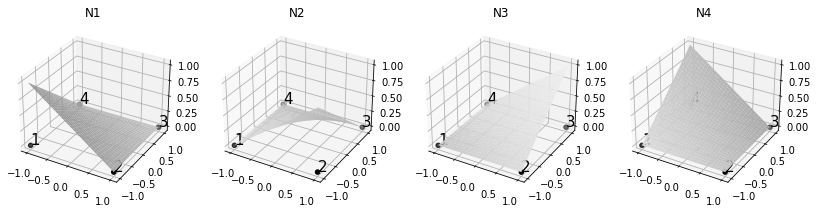

In [9]:
# Graphique de validation des Ni
validate_N_fun()

## Jacobian matrix for a bilinear quadrilateral element

The jacobian matrix $J$ for a 2 dimension reference element is done as follow : 

$[J] = \begin{bmatrix} \frac{\partial \vec{N}}{\partial \xi} \\ \frac{\partial \vec{N}}{\partial \eta} \end{bmatrix} \times \begin{bmatrix} \vec{x} & \vec{y} \end{bmatrix} $

With $N$ the shape function vector and $\vec{x}, \vec{y}$ the coordinates of the nodes in the $x$, $y$ domain.

We define $S$ so that : $S = \begin{bmatrix} \vec{x} & \vec{y} \end{bmatrix} $

In [1]:
import numpy as np

In [6]:
x = np.array([1, 2, 3, 3, 5, 6])
y = np.array([1, 2, 3, 4, 5, 6])
S = np.vstack([x.T, y.T])
S

array([[1, 2, 3, 3, 5, 6],
       [1, 2, 3, 4, 5, 6]])

In [10]:
x_1, x_2, x_3, x_4 = symbols("x_1 x_2 x_3 x_4")
y_1, y_2, y_3, y_4 = symbols("y_1 y_2 y_3 y_4")
X = Matrix([x_1, x_2, x_3, x_4]).T
Y = Matrix([y_1, y_2, y_3, y_4]).T
S = Matrix([[X], [Y]]).T
S

Matrix([
[x_1, y_1],
[x_2, y_2],
[x_3, y_3],
[x_4, y_4]])

We compute the $\bar{N}$  matrix which is equal to : $\begin{bmatrix} \frac{\partial \vec{N}}{\partial \xi} \\ \frac{\partial \vec{N}}{\partial \eta} \end{bmatrix}$

In [11]:
N_bar_1 = diff(N, xi)
N_bar_2 = diff(N, eta)

N_bar = Matrix([N_bar_1, N_bar_2])
N_bar

Matrix([
[eta/4 - 1/4, 1/4 - eta/4, eta/4 + 1/4, -eta/4 - 1/4],
[ xi/4 - 1/4, -xi/4 - 1/4,  xi/4 + 1/4,   1/4 - xi/4]])

We compute the Jacobian matrix $J$ : 

In [12]:
J = N_bar * S
J = simplify(J)
J

Matrix([
[x_1*(eta - 1)/4 - x_2*(eta - 1)/4 + x_3*(eta + 1)/4 - x_4*(eta + 1)/4, y_1*(eta - 1)/4 - y_2*(eta - 1)/4 + y_3*(eta + 1)/4 - y_4*(eta + 1)/4],
[    x_1*(xi - 1)/4 - x_2*(xi + 1)/4 + x_3*(xi + 1)/4 - x_4*(xi - 1)/4,     y_1*(xi - 1)/4 - y_2*(xi + 1)/4 + y_3*(xi + 1)/4 - y_4*(xi - 1)/4]])

The determinant of the $J$ matrix : 

In [13]:
J_det = det(J)
J_det = collect(collect(J_det, xi), eta)
J_det

eta*(-x_1*y_2/8 + x_1*y_3/8 + x_2*y_1/8 - x_2*y_4/8 - x_3*y_1/8 + x_3*y_4/8 + x_4*y_2/8 - x_4*y_3/8) + x_1*y_2/8 - x_1*y_4/8 - x_2*y_1/8 + x_2*y_3/8 - x_3*y_2/8 + x_3*y_4/8 + x_4*y_1/8 - x_4*y_3/8 + xi*(-x_1*y_3/8 + x_1*y_4/8 + x_2*y_3/8 - x_2*y_4/8 + x_3*y_1/8 - x_3*y_2/8 - x_4*y_1/8 + x_4*y_2/8)

Which can be rearranged as : 

$det(J) = A_0 + A_1\xi + A_2\eta$

with:

$A_0 = \frac{1}{8}(x_1y_2 - x_1y_4 - x_2y_1 + x_2y_3 - x_3y_2 + x_3y_4 + x_4y_1 - x_4y_3)$

$A_1 = \frac{1}{8}(-x_1y_3 + x_1y_4 + x_2y_3 - x_2y_4 + x_3y_1 - x_3y_2 - x_4y_1 + x_4y_2)$

$A_2 = \frac{1}{8}(-x_1y_2 + x_1y_3 + x_2y_1 - x_2y_4 - x_3y_1 + x_3y_4 + x_4y_2 - x_4y_3)$


The inverse of the jacobian matrix $j$ is usefull to express derivatives in the real coordinates from the natural coordinates, it can be expressed as follow :

Considering :  $J = \begin{bmatrix} a & b \\ c & d \end{bmatrix} $

Then :  $j = \frac{1}{det(J)}\begin{bmatrix} d & -b \\ -c & a \end{bmatrix} $

With : 

$ a = \frac{1}{4} (x_1(\eta - 1) - x_2(\eta - 1) + x_3(\eta + 1) - x_4(\eta + 1)) \\
  b = \frac{1}{4}(y_1(\eta - 1) - y_2(\eta - 1) + y_3(\eta + 1) - y_4(\eta + 1)) \\
  c = \frac{1}{4}(x_1(\xi - 1) - x_2(\xi + 1) + x_3(\xi + 1) - x_4(\xi - 1)) \\
  d = \frac{1}{4}(y_1(\xi - 1) - y_2(\xi + 1) + y_3(\xi + 1) - y_4(\xi - 1)) $

In [14]:
a = J[0]
b = J[1]
c = J[2]
d = J[3]

j_rearanged = Matrix([[d, -b],
            [-c, a]])

J_inv = (1/J_det)*j_rearanged

Global derivatives $(\frac{\partial}{\partial x}, \frac{\partial}{\partial y})$ can be expressed from the derivatives of the natural coordinates  with the inverse of the jacobian matrix : 

$ \begin{bmatrix} \frac{\partial}{\partial x} \\ \frac{\partial}{\partial y} \end{bmatrix} = \begin{bmatrix} j \end{bmatrix}  \times 
\begin{bmatrix} \frac{\partial}{\partial \xi} \\ \frac{\partial}{\partial \eta} \end{bmatrix}$

Computing the vector product yields : 

$\frac{\partial}{\partial x} = \frac{1}{det(J)}\ ( d\frac{\partial}{\partial \xi}\ -b\frac{\partial}{\partial \eta})$

$\frac{\partial}{\partial y} = \frac{1}{det(J)}\ ( -c\frac{\partial}{\partial \xi}\ +a\frac{\partial}{\partial \eta})$

## Constitutive relations for plane stress

From the vector field of displacement $\vec{U}(x,y)$ we compute the strain : 

$\begin{bmatrix} \epsilon_x \\ \epsilon_y \\ \epsilon_{xy} \end{bmatrix}  = \begin{bmatrix} \frac{\partial}{\partial x} & 0 \\ 0 & \frac{\partial}{\partial y} \\ \frac{\partial}{\partial y} & \frac{\partial}{\partial x} \end{bmatrix} \times \begin{bmatrix} u_x \\ u_y \end{bmatrix}$

The expression of strain $\vec{\epsilon}$ from the coordinates of the reference element with $(\xi, \eta)$ is obtained by the transformation associated to the inverse of the jacobian matrix $j$ : 

$\begin{bmatrix} \epsilon_x \\ \epsilon_y \\ \epsilon_{xy} \end{bmatrix}  = \frac{1}{det(J)}\
\begin{bmatrix} d\frac{\partial}{\partial \xi} - b\frac{\partial}{\partial \eta} & 0 \\
0 & -c\frac{\partial}{\partial \xi} + a\frac{\partial}{\partial \eta} \\
-c\frac{\partial}{\partial \xi} + a\frac{\partial}{\partial \eta} & d\frac{\partial}{\partial \xi} - b\frac{\partial}{\partial \eta} \end{bmatrix} \times \begin{bmatrix} u_{\xi} \\ u_{\eta} \end{bmatrix}$

## Strain matrix $B$

Replacing the displacement function with its approximation from the shape functions : 

$u(\xi, \eta) = \vec{N}\vec{u_e}$

where $u_e$ is the displacement at the nodes. 

$\vec{\epsilon} = \begin{bmatrix} j \end{bmatrix} \begin{bmatrix} \frac{\partial}{\partial x} & 0 \\ 0 & \frac{\partial}{\partial y} \\ \frac{\partial}{\partial y} & \frac{\partial}{\partial x} \end{bmatrix}  \vec{N}\vec{u_e}$

Then :

$\vec{\epsilon} = \begin{bmatrix} j \end{bmatrix}  B \vec{u_n}$ $\!$ where $B = LN$

Considering $N$ : 

In [15]:
N

Matrix([[(eta - 1)*(xi - 1)/4, -(eta - 1)*(xi + 1)/4, (eta + 1)*(xi + 1)/4, -(eta + 1)*(xi - 1)/4]])

We compute $\frac{\partial N}{\partial \xi}$ : 

In [16]:
dN_xi = diff(N, xi)
dN_xi

Matrix([[eta/4 - 1/4, 1/4 - eta/4, eta/4 + 1/4, -eta/4 - 1/4]])

And $\frac{\partial N}{\partial \eta}$ : 

In [17]:
dN_eta = diff(N, eta)
dN_eta

Matrix([[xi/4 - 1/4, -xi/4 - 1/4, xi/4 + 1/4, 1/4 - xi/4]])

Then assemble the $B$ matrix such as : 

$B_i = \begin{bmatrix} d\frac{\partial N_i}{\partial \xi} - b\frac{\partial N_i}{\partial \eta} & 0 \\
0 & -c\frac{\partial N_i}{\partial \xi} + a\frac{\partial N_i}{\partial \eta} \\
-c\frac{\partial N_i}{\partial \xi} + a\frac{\partial N_i}{\partial \eta} & d\frac{\partial N_i}{\partial \xi} - b\frac{\partial N_i}{\partial \eta} \end{bmatrix}$

For $i = (1, 2, 3, 4)$

Then : $B = \frac{1}{det(J)} \begin{bmatrix} B_1 & B_2 & B_3 & B_4 \end{bmatrix} $


In [18]:
B = zeros(3,8)
i = 0
for node in range(0,4):
    j = 2*node
    B[i,j] = d*dN_xi[node] - b*dN_eta[node]
    B[i+1, j+1] = -c*dN_xi[node] + a*dN_eta[node]
    B[i+2, j] = -c*dN_xi[node] + a*dN_eta[node]
    B[i+2, j+1] = d*dN_xi[node] - b*dN_eta[node]

B

Matrix([
[ (eta/4 - 1/4)*(y_1*(xi - 1)/4 - y_2*(xi + 1)/4 + y_3*(xi + 1)/4 - y_4*(xi - 1)/4) - (xi/4 - 1/4)*(y_1*(eta - 1)/4 - y_2*(eta - 1)/4 + y_3*(eta + 1)/4 - y_4*(eta + 1)/4),                                                                                                                                                                         0,  (1/4 - eta/4)*(y_1*(xi - 1)/4 - y_2*(xi + 1)/4 + y_3*(xi + 1)/4 - y_4*(xi - 1)/4) - (-xi/4 - 1/4)*(y_1*(eta - 1)/4 - y_2*(eta - 1)/4 + y_3*(eta + 1)/4 - y_4*(eta + 1)/4),                                                                                                                                                                          0,  (eta/4 + 1/4)*(y_1*(xi - 1)/4 - y_2*(xi + 1)/4 + y_3*(xi + 1)/4 - y_4*(xi - 1)/4) - (xi/4 + 1/4)*(y_1*(eta - 1)/4 - y_2*(eta - 1)/4 + y_3*(eta + 1)/4 - y_4*(eta + 1)/4),                                                                                                                                      

The above value should then be multiplied by $\frac{1}{det(J)}$ to obtain the $B$ matrix.

The obtained strain matrix $B$ will be different for every element with differing global coordinates as it is a function of $\vec{x}$ and $\vec{y}$.

## Isotropic compliance matrix $C$

The isotropic compliance matrix for plane stress goes as follow : 

$D = \frac{E}{1-v^2} \begin{bmatrix} 1 & \nu & 0 \\ \nu & 1 & 0 \\ 0 & 0 & \frac{1-\nu}{2} \end{bmatrix}$

It acts as a tensor between the stress and strain.

## Obtaining the element stiffness matrix

The element stiffness matrix is given by the following integral :

$K_e = \int_{V_e} \ B^T C B \ det(J) \ dV $

For a plane reference element with fixed stiffness : 

$K_e = \int_{-1}^{1} \int_{-1}^{1} \ t \ B^T C B \ det(J) \ d\eta \ d\xi \ $ With $t$ the tickness

## Element stiffness matrix validation

The numerical values are from : Example 13.1 in the [MATLAB Guide to Finite Elements](https://www.springer.com/gp/book/9783662052099) (p.283)


### Compliance matrix $C$

In [149]:
E = 210e6
nu = 0.3
C = E/(1 - nu ** 2) * Matrix([[1, nu, 0],
                              [nu, 1, 0],
                              [0, 0, (1-nu)/2]])
C = np.array(C).astype('float')
np.around(C/10e8,3)

array([[0.231, 0.069, 0.   ],
       [0.069, 0.231, 0.   ],
       [0.   , 0.   , 0.081]])

### Coordinates of the element

We take the following coordinates for the element :

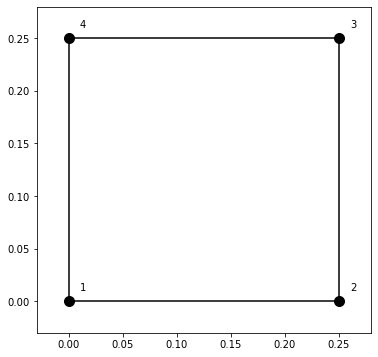

In [20]:
# Plotting the element for the example
x = [0, 0.25, 0.25, 0]
y = [0, 0, 0.25, 0.25]
element_plot(x,y)
plt.xlim((-0.03, 0.28))
plt.ylim((-0.03, 0.28))
plt.show()

### Computing the determinant of the Jacobian Matrix : 

$det(J) = A_0 + A_1\xi + A_2\eta$

with:

$A_0 = \frac{1}{8}(x_1y_2 - x_1y_4 - x_2y_1 + x_2y_3 - x_3y_2 + x_3y_4 + x_4y_1 - x_4y_3)$

$A_1 = \frac{1}{8}(-x_1y_3 + x_1y_4 + x_2y_3 - x_2y_4 + x_3y_1 - x_3y_2 - x_4y_1 + x_4y_2)$

$A_2 = \frac{1}{8}(-x_1y_2 + x_1y_3 + x_2y_1 - x_2y_4 - x_3y_1 + x_3y_4 + x_4y_2 - x_4y_3)$

In [21]:
xi, eta = symbols('xi eta')

x = [0, 0.25, 0.25, 0]
y = [0, 0, 0.25, 0.25]

# det(J) = A0 + A1*xi + A2*eta

A0 = (1/8) * (x[0]*y[1] - x[0]*y[3] - x[1]*y[0] + x[1]*y[2] - x[2]*y[1] + x[2]*y[3] + x[3]*y[0] - x[3]*y[2])

A1 = (1/8) * (-x[0]*y[2] + x[0]*y[3] + x[1]*y[2] - x[1]*y[3] + x[2]*y[0] - x[2]*y[1] - x[3]*y[0] + x[3]*y[1])

A2 = (1/8) * (-x[0]*y[1] + x[0]*y[2] + x[1]*y[0] - x[1]*y[3] - x[2]*y[0] + x[2]*y[3] + x[3]*y[1] - x[3]*y[2])

det_J = A0 + A1*xi + A2*eta
det_J = J_det.subs([(x_1,x[0]), (x_2, x[1]), (x_3, x[2]), (x_4, x[3]), (y_1, y[0]), (y_2, y[1]), (y_3, y[2]), (y_4, y[3])])
det_J

0.0156250000000000

Because the element has $90^o$ angles, the determinant of the jacobian matrix is constant.

### Computing the $B$ matrix

With the values of the jacobian matrix : 
$ a = \frac{1}{4} (x_1(\eta - 1) - x_2(\eta - 1) + x_3(\eta + 1) - x_4(\eta + 1)) \\
  b = \frac{1}{4}(y_1(\eta - 1) - y_2(\eta - 1) + y_3(\eta + 1) - y_4(\eta + 1)) \\
  c = \frac{1}{4}(x_1(\xi - 1) - x_2(\xi + 1) + x_3(\xi + 1) - x_4(\xi - 1)) \\
  d = \frac{1}{4}(y_1(\xi - 1) - y_2(\xi + 1) + y_3(\xi + 1) - y_4(\xi - 1)) $
  
And the value of the B matrix : 

$B_i = \frac{1}{det(J)} \begin{bmatrix} d\frac{\partial N_i}{\partial \xi} - b\frac{\partial N_i}{\partial \eta} & 0 \\
0 & -c\frac{\partial N_i}{\partial \xi} + a\frac{\partial N_i}{\partial \eta} \\
-c\frac{\partial N_i}{\partial \xi} + a\frac{\partial N_i}{\partial \eta} & d\frac{\partial N_i}{\partial \xi} - b\frac{\partial N_i}{\partial \eta} \end{bmatrix}$

and

$B = \begin{bmatrix} B_1 & B_2 & B_3 & B_4 \end{bmatrix} $

In [22]:
B_copy = (1/det_J)*B.subs([(x_1,x[0]), (x_2, x[1]), (x_3, x[2]), (x_4, x[3]), (y_1, y[0]), (y_2, y[1]), (y_3, y[2]), (y_4, y[3])])
B_copy

Matrix([
[2.0*eta - 2.0,             0, 2.0 - 2.0*eta,             0, 2.0*eta + 2.0,             0, -2.0*eta - 2.0,              0],
[            0,  2.0*xi - 2.0,             0, -2.0*xi - 2.0,             0,  2.0*xi + 2.0,              0,   2.0 - 2.0*xi],
[ 2.0*xi - 2.0, 2.0*eta - 2.0, -2.0*xi - 2.0, 2.0 - 2.0*eta,  2.0*xi + 2.0, 2.0*eta + 2.0,   2.0 - 2.0*xi, -2.0*eta - 2.0]])

### Computing the function to integrate

With $I$ such as : $I = B^T C B \ det(J)$ 

In [23]:
I = B_copy.T*C*B_copy*det_J
# A 8x8 matrix with unknowns, too large to display

### integrating to find the element stiffness matrix $K_e$

with $t=0.025$

In [33]:
t = 0.025 # m
K_e = t * integrate(integrate(I, (xi, -1, 1)), (eta, -1,1))
np.around(np.array(K_e/10e5).astype('float'),3)

array([[ 2.596,  0.937, -1.587, -0.072, -1.298, -0.937,  0.288,  0.072],
       [ 0.937,  2.596,  0.072,  0.288, -0.937, -1.298, -0.072, -1.587],
       [-1.587,  0.072,  2.596, -0.937,  0.288, -0.072, -1.298,  0.937],
       [-0.072,  0.288, -0.937,  2.596,  0.072, -1.587,  0.937, -1.298],
       [-1.298, -0.937,  0.288,  0.072,  2.596,  0.937, -1.587, -0.072],
       [-0.937, -1.298, -0.072, -1.587,  0.937,  2.596,  0.072,  0.288],
       [ 0.288, -0.072, -1.298,  0.937, -1.587,  0.072,  2.596, -0.937],
       [ 0.072, -1.587,  0.937, -1.298, -0.072,  0.288, -0.937,  2.596]])

In [37]:
# Matrix obtained from the book [MATLAB Guide to Finite Elements]
np.around(K_ele_13_1()/10e5, 3)

array([[ 2.596,  0.938, -1.586, -0.072, -1.298, -0.938,  0.288,  0.072],
       [ 0.938,  2.596,  0.072,  0.288, -0.938, -1.298, -0.072, -1.586],
       [-1.586,  0.072,  2.596, -0.938,  0.288, -0.072, -1.298,  0.938],
       [-0.072,  0.288, -0.938,  2.596,  0.072, -1.586,  0.938, -1.298],
       [-1.298, -0.938,  0.288,  0.072,  2.596,  0.938, -1.586, -0.072],
       [-0.938, -1.298, -0.072, -1.586,  0.938,  2.596,  0.072,  0.288],
       [ 0.288, -0.072, -1.298,  0.938, -1.586,  0.072,  2.596, -0.938],
       [ 0.072, -1.586,  0.938, -1.298, -0.072,  0.288, -0.938,  2.596]])

## A Function to integrate without symbolic calculus

In [25]:
def Integrand(x, y, C):
    """ Create a function object to be integrated """
    
    A0 = (1/8) * (x[0]*y[1] - x[0]*y[3] - x[1]*y[0] + x[1]*y[2] - x[2]*y[1] + x[2]*y[3] + x[3]*y[0] - x[3]*y[2])
    A1 = (1/8) * (-x[0]*y[2] + x[0]*y[3] + x[1]*y[2] - x[1]*y[3] + x[2]*y[0] - x[2]*y[1] - x[3]*y[0] + x[3]*y[1])
    A2 = (1/8) * (-x[0]*y[1] + x[0]*y[2] + x[1]*y[0] - x[1]*y[3] - x[2]*y[0] + x[2]*y[3] + x[3]*y[1] - x[3]*y[2])

    def fun(zi):
        """ evaluate the integrand at points xi and eta"""
        
        xi_s = zi[0]
        eta_s = zi[1]
        result = []
        
        for xi, eta in zip(xi_s, eta_s):
            det_J = A0 + A1*xi + A2*eta # scalar
            dN_xi  = np.array([eta/4 - 1/4, 1/4 - eta/4, eta/4 + 1/4, -eta/4 - 1/4]) # vector
            dN_eta = np.array([xi/4 - 1/4, -xi/4 - 1/4, xi/4 + 1/4, 1/4 - xi/4]) # vector

            a = 0.25*(x[0]*(eta - 1) - x[1]*(eta - 1) + x[2]*(eta + 1) - x[3]*(eta + 1)) # scalar
            b = 0.25*(y[0]*(eta - 1) - y[1]*(eta - 1) + y[2]*(eta + 1) - y[3]*(eta + 1))
            c = 0.25*(x[0]*(xi - 1) - x[1]*(xi + 1) + x[2]*(xi + 1) - x[3]*(xi - 1))
            d = 0.25*(y[0]*(xi - 1) - y[1]*(xi + 1) + y[2]*(xi + 1) - y[3]*(xi - 1))

            B = np.zeros((3,8))
            B[0, range(0,7,2)] = d*dN_xi - b*dN_eta
            B[1, range(1,8,2)] = -c*dN_xi + a*dN_eta
            B[2, range(0,7,2)] = -c*dN_xi + a*dN_eta
            B[2, range(1,8,2)] = d*dN_xi - b*dN_eta
            B = (1/det_J)*B
            
            result.append(B.transpose() @ C @ B*det_J)
            
            output = np.zeros((8,8, len(xi_s)))
            
            for i in range(0,8):
                for j in range(0,8):
                    for point in range(len(result)):
                        output[i,j, point] = result[point][i,j]
        return output
    
    return fun

def element_stiffness_matrix(x, y, C, t):
    """
    Compute the element stiffness matrix from the node coordinates, the stress tensor and element thickness
    """
    
    I = Integrand(x, y, C) # create the function to integrate
    scheme = quadpy.c2.get_good_scheme(2) # integration scheme
    k = t*scheme.integrate(I, quadpy.c2.rectangle_points([-1, 1], [-1, 1]))
    
    return k

In [38]:
K_e = element_stiffness_matrix(x, y, C, 0.025)
np.around(K_e/10e5,3)

array([[ 2.596,  0.937, -1.587, -0.072, -1.298, -0.937,  0.288,  0.072],
       [ 0.937,  2.596,  0.072,  0.288, -0.937, -1.298, -0.072, -1.587],
       [-1.587,  0.072,  2.596, -0.937,  0.288, -0.072, -1.298,  0.937],
       [-0.072,  0.288, -0.937,  2.596,  0.072, -1.587,  0.937, -1.298],
       [-1.298, -0.937,  0.288,  0.072,  2.596,  0.937, -1.587, -0.072],
       [-0.937, -1.298, -0.072, -1.587,  0.937,  2.596,  0.072,  0.288],
       [ 0.288, -0.072, -1.298,  0.937, -1.587,  0.072,  2.596, -0.937],
       [ 0.072, -1.587,  0.937, -1.298, -0.072,  0.288, -0.937,  2.596]])

### Time saved with the vectorised function : 

In [27]:
# Symbolic calculus
def this():
    det_J = J_det.subs([(x_1,x[0]), (x_2, x[1]), (x_3, x[2]), (x_4, x[3]), (y_1, y[0]), (y_2, y[1]), (y_3, y[2]), (y_4, y[3])])
    B_copy = (1/det_J)*B.subs([(x_1,x[0]), (x_2, x[1]), (x_3, x[2]), (x_4, x[3]), (y_1, y[0]), (y_2, y[1]), (y_3, y[2]), (y_4, y[3])])
    I = B_copy.T*C*B_copy*det_J
    K_e = 0.025 * integrate(integrate(I, (xi, -1, 1)), (eta, -1,1))

%timeit this()

3.98 s ± 425 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [28]:
# Numeric integration
%timeit K_e = element_stiffness_matrix(x, y, C, 0.025)

34.1 ms ± 690 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)


## Formulation of the A matrix for in plane load :

$ A = \int_{-z/2}^{z/2} Q\: dz   $

For a domain discretized in $n$ plies with constant $Q$ matrix

$ A = \sum_{i=1}^n \int_{z_i}^{z_{i+1}} Q_i dz $

Computing the integral

$ A = \sum_{i=1}^n Q_i \: z \: \vert_{z_i}^{z_{i+1}}$

$ A = \sum_{i=1}^n Q_i (z_{i+1} - z_i) $

Case where the $n$ plies have constant thickness $h_i$

$ A = \sum_{i=1}^n Q_i h_i $

If $n=1$, then $A=Q h$


And with $C$ such that : 

$$\vec{\sigma} = C \vec{\epsilon} $$

Then : 

$$ C = \frac{A}{nh_i} $$

with $ \vec{\epsilon} = \begin{bmatrix} \epsilon_x \\ \epsilon_y \\ \epsilon_{xy} \end{bmatrix}$ and $\vec{\sigma} = \begin{bmatrix} \sigma_x \\ \sigma_y \\ \sigma_z \end{bmatrix} $

## Validating the A matrix formulation and plane stress model

### Test problem 

Material: **T300_N5208**

Variable angle layup [0 / 45 / -45 / 0 / 0 / -45 / 45 / 0] with 50 kN force in the x direction.

Solution : $ \vec{\epsilon} = \begin{bmatrix} 0.4809 \\ -0.3245 \\  0. \end{bmatrix} $


In [151]:
# T300_N5208 material proprieties
Ex = 181e9 # Pa
Ey = 10.3e9 # Pa
Es = 7.17e9
v = 0.28
ho = 0.125
T300_N5208 = Material(Ex, Ey, Es, v, ho)

### Finie element formulation

A single 1m x 1m element : 

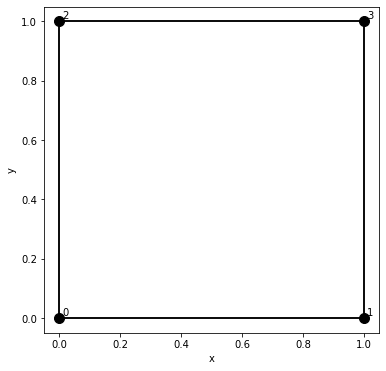

In [152]:
mesh = RectangleQuadMesh(1, 1, 1, 1)
mesh.plot()

### Compliance matrix $C$

1. Computing the $Q$ matrices 

In [119]:
# Computing the Q matrices for the material
plies = [0, 45, -45, 0, 0, -45, 45, 0]
nb_plies = len(plies)
h_t = nb_plies * T300_N5208.hi
Q_mats = []

for angle in plies:
    Q_mats.append(Q_mat(T300_N5208, angle))

2. Computing the $A$ matrix

From :

$$A = \sum_{i=1}^n Q_i h_i $$

In [155]:
A = 0
for Q in Q_mats:
    A += Q * T300_N5208.hi
    
np.around(A/10e8, 3)

array([[0.119, 0.023, 0.   ],
       [0.023, 0.034, 0.   ],
       [0.   , 0.   , 0.027]])

3. Computing the compliance matrix $C$

In [158]:
C = A / (nb_plies * T300_N5208.hi)
np.around(C/10e8, 3)

array([[0.119, 0.023, 0.   ],
       [0.023, 0.034, 0.   ],
       [0.   , 0.   , 0.027]])

### Element stiffness matrix

Computing the element stiffness matrix from the compliance matrix

1. Getting the node coordinates

In [122]:
x = []
y = []
for ele in mesh.CONEC:
    for node in ele:
        x.append(mesh.CORG[node][0])
        y.append(mesh.CORG[node][1])

2. Computing the element stifness matrix for the element

In [167]:
K_ele = element_stiffness_matrix(x, y, C, h_t)
np.around(K_ele/10e3, 2)

array([[ 4.87,  1.24, -3.53, -0.11, -2.44, -1.24,  1.09,  0.11],
       [ 1.24,  2.01,  0.11, -0.34, -1.24, -1.01, -0.11, -0.67],
       [-3.53,  0.11,  4.87, -1.24,  1.09, -0.11, -2.44,  1.24],
       [-0.11, -0.34, -1.24,  2.01,  0.11, -0.67,  1.24, -1.01],
       [-2.44, -1.24,  1.09,  0.11,  4.87,  1.24, -3.53, -0.11],
       [-1.24, -1.01, -0.11, -0.67,  1.24,  2.01,  0.11, -0.34],
       [ 1.09, -0.11, -2.44,  1.24, -3.53,  0.11,  4.87, -1.24],
       [ 0.11, -0.67,  1.24, -1.01, -0.11, -0.34, -1.24,  2.01]])

### Assembling the system

1. Assembling the global Stiffness matrix $K$

In [124]:
K = K_assemble(mesh, K_ele)

For a system with one element, $ K = K_{ele} $

2. Testing the conditional value of the system matrix

In [125]:
np.linalg.cond(K)

1.0887458268901075e+18

Adding a small value to the diagonal to reduce the conditional value : 

In [159]:
Conditioning_matrix = np.identity(K.shape[0])
K = K + Conditioning_matrix
np.linalg.cond(K)

7343.979498326469

### Creating the force vector

In [160]:
Applied_Force = 50000  # 50 kN
F = np.zeros(K.shape[0])

positive_load_nodes = np.array([1, 3])
negative_load_node = np.array([0, 2])

F[(2*positive_load_nodes)] = Applied_Force/2
F[2*negative_load_node] = -Applied_Force/2
F

array([-25000.,      0.,  25000.,      0., -25000.,      0.,  25000.,
            0.])

### Solving for displacement

In [161]:
U = linalg.solve(K, F)
U

array([-0.24037628,  0.16212526,  0.24037628,  0.16212526, -0.24037628,
       -0.16212526,  0.24037628, -0.16212526])

### Mapping the $x$ and $y$ components

In [163]:
U
Ux = U[np.arange(0,len(U), 2)]
Ux = np.flip(Ux.reshape(2,2), axis=0)

Uy = U[np.arange(1,len(U), 2)]
Uy = np.flip(Uy.reshape(2,2), axis=0)

### Plotting the displacement

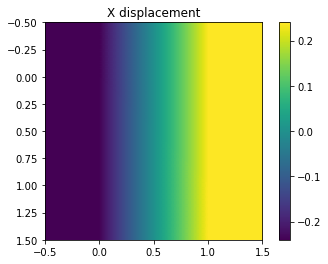

In [168]:
plt.figure(1)
plt.imshow(Ux, interpolation='bilinear')
plt.title("X displacement")
plt.colorbar()
plt.show()

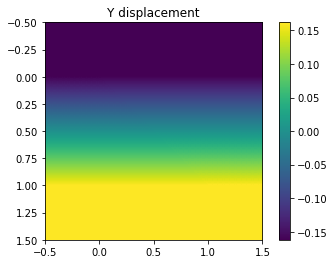

In [169]:
plt.figure(2)
plt.imshow(Uy, interpolation='bilinear')
plt.title("Y displacement")
plt.colorbar()
plt.show()

### Computing the strains
$\epsilon_x$ strain (Theoretical value = 0.4809)

In [165]:
ex = -U[0] + U[2]
ex # Theoretical value = 0.4809

0.4807525658748474

$\epsilon_y$ strain (Theoretical value = -0.3245)

In [170]:
ey = -U[1] + U[5]
ey # Theoretical value = -0.3245

-0.32425051581427433